In [1]:
%matplotlib inline 
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import spearmanr

In [4]:
from access_biology_data import meta, relations, annotation, properties
from access_literature_data import medline
from access_science_shared import standardizer

import sys
sys.path.append('./../src/')
from aging_tools import inout, export, calculators
from access_aging_data import chaperome, earlier_studies, sequencing


In [5]:
import random

In [6]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

In [7]:
out_folder = '191022_mouse_models_vs_max_accuracy'
in_folder = '190406_predict_fold_change_mouse'

In [8]:
save_images = False

In [9]:
from narrative import nar181026_heat_confidence_genes

In [10]:
ref_genes = standardizer.reference_genes(10090, 'orp')  # only consider supported protein coding-genes

In [11]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 
pfus=[0]

In [12]:
all_de = all_de[
    (all_de['younger'] == 4) & 
    (all_de['is_detected'] == True) &
    (all_de['de_unit'] == 'both') &
    (all_de['tissue'].isin(tissues_to_consider)) &
    (all_de['pfu'].isin(pfus)) & 
    (all_de['gene_ncbi'].isin(ref_genes))
]
all_de['significant'] = all_de['padj'] < 0.05

In [13]:
sign = all_de[['condition', 'significant']].groupby('condition').agg(sum)

In [14]:
agg = []

for condition in all_de['condition'].unique():

    p = export.get_material_path(
        '{}/predictions_{}.csv'.format(in_folder, condition))
    if os.path.exists(p):
        agg.append(pd.read_csv(p))


df = pd.concat(agg).rename(columns={'Unnamed: 0': 'condition'}).set_index('condition')
df['mean'] = df.mean(1)
df.loc[:, 'min'] = df.min(1)
df.loc[:, 'max'] = df.max(1)

In [15]:
d = pd.merge(sign.reset_index(), df[['mean', 'max', 'min']].reset_index())
# d = pd.merge(sign.reset_index(), df[['mean']].reset_index())


f = d['significant'] > 0
d.loc[f, 'log_significant'] = d.loc[f, 'significant'].apply(lambda x: np.log10(x))

In [16]:
predictions = d.copy()

In [17]:
ref_genes = standardizer.reference_genes(10090, 'orp')  # only consider supported protein coding-genes

all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 
pfus=[0]

first = all_de[
    (all_de['younger'] == 4) & 
    (all_de['is_detected'] == True) &
    (all_de['de_unit'] == 'first') &
    (all_de['tissue'].isin(tissues_to_consider)) &
    (all_de['pfu'].isin(pfus)) & 
    (all_de['gene_ncbi'].isin(ref_genes))
]

second = all_de[
    (all_de['younger'] == 4) & 
    (all_de['is_detected'] == True) &
    (all_de['de_unit'] == 'second') &
    (all_de['tissue'].isin(tissues_to_consider)) &
    (all_de['pfu'].isin(pfus)) & 
    (all_de['gene_ncbi'].isin(ref_genes))
]


ages = [9, 12, 18, 24]

out = pd.DataFrame(index=tissues_to_consider, columns=ages)

from scipy.stats import spearmanr

agg = []

for tissue in tissues_to_consider:
    for age in ages:
        fi = first[
            (first['older']==age) & 
            (first['tissue']==tissue)            
        ][['gene_ncbi', 'o_over_y']]
        
        
        se = second[
            (second['older']==age) & 
            (second['tissue']==tissue)          
        ][['gene_ncbi', 'o_over_y']]
        
        m =pd.merge(fi, se, on='gene_ncbi', how='inner', suffixes=('_fi', '_se'))
        
        di = dict()
        di['tissue'] = tissue
        di['age'] = age
        di['rho'] = spearmanr(m['o_over_y_fi'], m['o_over_y_se'])[0]
        agg.append(di)

o = pd.DataFrame(agg)

# h = o.pivot(index='tissue', columns='age', values='rho')

# f = h>0

# h[~f] = 0

In [18]:
predictions.head()

,condition,significant,mean,max,min,log_significant
0,Adrenal_0_4_12,464.0,0.309188,0.350171,0.259096,2.666518
1,Adrenal_0_4_18,974.0,0.237433,0.263238,0.192532,2.988559
2,Adrenal_0_4_24,647.0,0.285258,0.328871,0.252957,2.810904
3,Adrenal_0_4_9,30.0,0.174306,0.207960,0.122643,1.477121
4,BAT_0_4_12,70.0,0.189746,0.242940,0.152044,1.845098


In [19]:
r = pd.merge(
    pd.merge(
        all_de.loc[
            (all_de['younger']==4) & (all_de['pfu']==0), 
            ['condition', 'older', 'tissue']].drop_duplicates(),
        o.rename(columns={'age': 'older'})
    ),
    predictions[['condition', 'mean', 'max', 'min']]
)


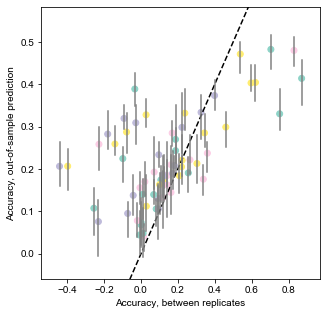

In [20]:
plt.figure(figsize=(5, 5))

plt.plot([-1, 1], [-1, 1], '--k')
plt.scatter(r['rho'], r['mean'], c=r['older'], cmap='Set3')
plt.xlabel('Accuracy, between replicates')
plt.ylabel('Accuracy, out-of-sample prediction')



plt.xlim(r['rho'].min()-0.1, r['rho'].max()+0.1)
plt.ylim(r['mean'].min()-0.1, r['mean'].max()+0.1)

for j in predictions.index:
    plt.plot(
        [r.loc[j, 'rho'], r.loc[j, 'rho']], 
        [r.loc[j, 'min'], r.loc[j, 'max']],
        'grey')

if save_images:
    export.export_image(
    '{}/scatter_with_bar.pdf'.format(out_folder))

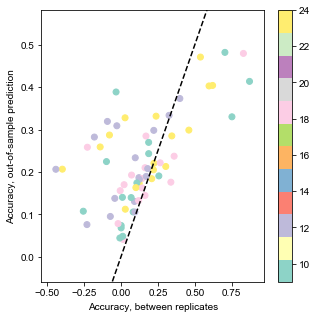

In [21]:
plt.figure(figsize=(5, 5))

plt.plot([-1, 1], [-1, 1], '--k')
plt.scatter(r['rho'], r['mean'], c=r['older'], cmap='Set3')
plt.xlabel('Accuracy, between replicates')
plt.ylabel('Accuracy, out-of-sample prediction')

plt.colorbar()

plt.xlim(r['rho'].min()-0.1, r['rho'].max()+0.1)
plt.ylim(r['mean'].min()-0.1, r['mean'].max()+0.1)


if save_images:
    export.export_image(
    '{}/scatter.pdf'.format(out_folder))

In [22]:
r['rho'].median()

0.11945255335166144

In [23]:
r['mean'].median()

0.20665302275262837

In [24]:
np.quantile(r['rho'], 0.25)

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


nan

In [27]:
np.quantile(r['rho'].dropna(), 0.25)

-0.002047111405567523

In [28]:
np.quantile(r['rho'].dropna(), 0.75)

0.23061232233953743

In [29]:
np.quantile(r['mean'].dropna(), 0.25)

0.14369198860322316

In [30]:
np.quantile(r['mean'].dropna(), 0.75)

0.2878170890349824

In [22]:
r[r['rho']>0.5].sort_values('rho')

,condition,older,tissue,rho,mean,max,min
46,Kidney_0_4_24,24.0,Kidney,0.538482,0.471329,0.500435,0.427534
63,SI_0_4_24,24.0,SI,0.596738,0.403170,0.445528,0.385018
33,LI_0_4_24,24.0,LI,0.620971,0.404364,0.446379,0.360635
36,Kidney_0_4_9,9.0,Kidney,0.704399,0.482377,0.515712,0.435595
40,Heart_0_4_9,9.0,Heart,0.751957,0.330360,0.389649,0.292652
53,LI_0_4_18,18.0,LI,0.829725,0.479915,0.510783,0.442318
20,Cerebellum_0_4_9,9.0,Cerebellum,0.871107,0.413945,0.458401,0.351981


In [23]:
predictions.head()

,condition,significant,mean,max,min,log_significant
0,Adrenal_0_4_12,464.0,0.309188,0.350171,0.259096,2.666518
1,Adrenal_0_4_18,974.0,0.237433,0.263238,0.192532,2.988559
2,Adrenal_0_4_24,647.0,0.285258,0.328871,0.252957,2.810904
3,Adrenal_0_4_9,30.0,0.174306,0.207960,0.122643,1.477121
4,BAT_0_4_12,70.0,0.189746,0.242940,0.152044,1.845098


In [24]:
if save_images:
    export.export_full_frame('{}/max_prediction.xlsx'.format(out_folder), r, save_index=False)

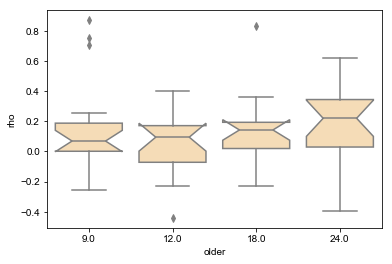

In [25]:
sns.boxplot(x='older', y='rho', data=r, notch=True, color='navajowhite')

if save_images:
    export.export_image(
    '{}/rho.pdf'.format(out_folder))

In [26]:
from scipy.stats import mannwhitneyu

In [27]:
mannwhitneyu(
    r[r['older']==9]['rho'],
    r[r['older']==24]['rho'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=113.0, pvalue=0.28563352706656997)

In [28]:
r[r['rho']>0.2]['older'].value_counts()

24.0    10
9.0      4
18.0     4
12.0     3
Name: older, dtype: int64